In [1]:
!nvidia-smi
%matplotlib inline

Sun Jul 13 00:15:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:E3:00.0 Off |                    0 |
| N/A   31C    P0             52W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import pandas as pd
import json
import re
import numpy as np
from typing import List, Optional, Dict, Any
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
import torch

In [3]:
def obtain_results_without(input_csv, filter_set):
    result_df = pd.read_csv(input_csv)
    result_df = result_df[result_df['direct_source']!=filter_set]
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()
    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

# Loading files

In [4]:
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)

# NL prompts - only one wording

## Loading the model

In [5]:
Qwen3_4B = "Qwen/Qwen3-4B"

import os
os.environ['TRANSFORMERS_CACHE'] = '/scratch-local/yhuang/huggingface_cache'
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(Qwen3_4B, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(Qwen3_4B)

# 将模型移到可用设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

cuda


## Helper functions

In [7]:
system_prompt = """
You are an expert analyst. Your task is to analyze and determine whether an input user query is "fully specified" or "underspecified".

"""

In [8]:
definitions_and_detailed_instructions = """
In what follows, I'll give you detailed definitions of "underspecified" and "fully specified" queries.

For "underspecified" queries, they belong to 4 main categories:

- **Missing necessary components**: There is a strong perception that for at least one expression within the query, a commonly expected component conceptually tied to it is missing, thus its semantic interpretation is left with an unfilled slot. As a result, the meaning of the whole query is underspecified.

- **Undetermined lexicons or references**: The query contains at least one expression of lexical or referential ambiguity. For this lexical or referential ambiguous expression,  multiple same-level entities or concepts can be mapped to it and serve as potential lexical entries or referents. It’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole query is underspecified.

- **Undetermined perspective or granularity**: The query contains at least one expression where the general meaning is in place, but its specific interpretation can still vary based on different perspectives or granularities adopted. Multiple interpretations of different levels or natures are plausible for such an expression, and it’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole query is underspecified.

- **Undetermined standard or preference**: The query contains at least one expression where the general meaning is in place, but its specific interpretation is vague due to unspecified contextual standards or subjective criteria. A wide range of fine-grained interpretations is possible according to contextual or subjective needs, and it’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole query is underspecified.

There is only one same-name category of "fully specified" queries, defined as follows:

- **fully specified**: The given query is totally clear and definitive, and it doesn't belong to any provided category of "underspecified" queries.


"""

In [9]:
example_intro = """
Here are examples of how to analyze queries:

"""

In [10]:
task_text = """

When analyzing a given query, think step by step in an explicit way:

First, provide "reasoning" regarding whether it belongs to any of the provided categories of "underspecified" queries or the category of "fully specified" queries.

Second, assign a "category" to it. It can belong to multiple categories of "underspecified" at the same time, but categories of "underspecified" and the category of "fully specified" are mutual-exclusive.

Lastly, based on the "category" assigned, determine a "judgment" on whether it is "underspecified" or "fully specified". Categories of "underspecified" can only lead to a "underspecified" judgment, while the category of "fully specified" can only lead to a "fully specified" judgment.

Now analyze the following query:

{"query": "TARGET"}

Think step by step as illustrated and provide your analysis in the following JSON format:
{"query": "TARGET", "reasoning": "[YOUR_DETAILED_REASONING]", "category": "[CATEGORY]", "judgment": "[fully specified/underspecified]"}
"""

In [11]:
def batch_generate_responses_qwen3(prompts, system_prompt=system_prompt,
                             temperature=0.001, max_new_tokens=10000, batch_size=4,
                             enable_thinking=True, parse_thinking=True):
    """
    批量生成Qwen 3模型的回复

    参数:
        prompts: 字符串列表，每个字符串是一个提示词
        system_prompt: 系统提示词
        max_new_tokens: 生成的最大token数，默认为512
        batch_size: 每批处理的提示词数量，默认为4
        enable_thinking: 是否启用思考模式，默认为True
        parse_thinking: 是否解析思考内容，默认为True

    返回:
        如果parse_thinking=True，返回(思考内容列表, 回复内容列表)的元组
        如果parse_thinking=False，返回回复列表
    """

    responses = []
    thinking_contents = [] if parse_thinking else None

    # 按批次处理
    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        batch_texts = []

        # 为每个提示词准备输入文本
        for prompt in batch_prompts:
            if system_prompt:
                messages = [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": prompt}
                ]
            else:
                messages = [
                    {"role": "user", "content": prompt}
                ]

            text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True,
                enable_thinking=enable_thinking  # 启用思考模式
            )
            batch_texts.append(text)

        # 批量编码输入
        model_inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(model.device)

        # 生成回复
        with torch.no_grad():
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                top_p=0.9,
                repetition_penalty=1.2
            )

        # 处理生成的回复
        batch_responses = []
        batch_thinking = [] if parse_thinking else None

        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids):
            response_ids = output_ids[len(input_ids):].tolist()

            if parse_thinking and enable_thinking:
                # 解析思考内容
                try:
                    # 寻找</think>对应的token ID (151668)
                    index = len(response_ids) - response_ids[::-1].index(151668)
                except ValueError:
                    index = 0

                thinking_content = tokenizer.decode(response_ids[:index], skip_special_tokens=True).strip("\n")
                content = tokenizer.decode(response_ids[index:], skip_special_tokens=True).strip("\n")

                batch_thinking.append(thinking_content)
                batch_responses.append(content)
            else:
                # 不解析思考内容，直接返回完整回复
                response = tokenizer.decode(response_ids, skip_special_tokens=True)
                batch_responses.append(response)

        responses.extend(batch_responses)
        if parse_thinking:
            thinking_contents.extend(batch_thinking)

    if parse_thinking:
        return thinking_contents, responses
    else:
        return responses

def get_judgments_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    judgments = []

    for i, response in enumerate(responses):
        judgment = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                judgment = data.get('judgment')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    judgment = data.get('judgment')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"judgment"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                judgment = match.group(1)

        if judgment is None:
            print(f"Warning: response {i} cannot retrieve judgment")
            print(f"Respond content: {response[:200]}...")
            judgment = "error"

        judgments.append(judgment)

    return judgments



def run_experiment(input_prompts, test_df):
  output = batch_generate_responses_qwen3(input_prompts)
  df = test_df.copy()
  df['thinking'] = output[0]
  df['model_response'] = output[1]
  to_process = output[1]
  processed_judgments = get_judgments_from_responses(to_process)
  df['model_pred'] = processed_judgments

  return df

def retrieve_results(result_df, output_name):
  processed_judgments = result_df['model_pred'].tolist()

  if "error" in processed_judgments:
    print("There are unrecognized labels.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error found, directly process the data.")
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()

    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

In [12]:
def prepare_test_prompts(test_df, task_text, learning_df=None, instruction_text=None, example_head=None, theory=False):
  print("Start preparing prompts...")
  if learning_df is not None and instruction_text is not None:
    print(f"# learning samples: {len(learning_df)}")
    examples = []
    if theory:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "reasoning": row['reasoning'],
                "category": row['category'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + example_head + examples_text + task_text
    else:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + example_head + examples_text + task_text
  elif learning_df is None and instruction_text is not None:
    base_prompt = instruction_text + task_text

  else:
    base_prompt = task_text

  print(f"# Testing data points: {len(test_df)}")
  test_prompts = []
  for _, row in test_df.iterrows():
    query = row['request']
    complete_prompt = base_prompt.replace("TARGET", query)
    test_prompts.append(complete_prompt)

  print(f"Generation complete: {len(test_prompts)} prompts")

  avg_length = sum(len(p) for p in test_prompts) // len(test_prompts)
  print(f"Average prompt length: {avg_length:,} bytes (~{avg_length//4:,} tokens)")

  return test_prompts

## Qwen3-4B NL FULL

## TRIAL

In [27]:
trial_prompts = prepare_test_prompts(df_few_shots, task_text, learning_df=df_in_context_learning, instruction_text=definitions_and_detailed_instructions, example_head=example_intro, theory=True)
print(trial_prompts[0])

Start preparing prompts...
# learning samples: 150
# Testing data points: 12
Generation complete: 12 prompts
Average prompt length: 74,849 bytes (~18,712 tokens)

In what follows, I'll give you detailed definitions of "underspecified" and "fully specified" queries.

For "underspecified" queries, they belong to 4 main categories:

- **Missing necessary components**: There is a strong perception that for at least one expression within the query, a commonly expected component conceptually tied to it is missing, thus its semantic interpretation is left with an unfilled slot. As a result, the meaning of the whole query is underspecified.

- **Undetermined lexicons or references**: The query contains at least one expression of lexical or referential ambiguity. For this lexical or referential ambiguous expression,  multiple same-level entities or concepts can be mapped to it and serve as potential lexical entries or referents. It’s impossible to fully determine which one is intended based on 

In [28]:
trial_df = run_experiment(trial_prompts, df_few_shots)
trial_df

100%|██████████| 12/12 [11:04<00:00, 55.36s/it]


,request,gold_analysis,gold_thought,gold_category,gold_judgment,direct_source,thinking,model_response,model_pred
0,When did the nuclear accident happen?,"{""predicate"": ""happen"", ""argument_time"": ""when...","The predicate ""happen"" is specified; its argum...",underspecified referential/indexical argument,underspecified,CoCoNot,"<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When did the nuclear accident h...",underspecified
1,I need help picking out a professional wardrob...,"{""predicate"": ""provide"", ""argument_agent"": ""yo...","The predicate ""provide"" is specified; its argu...",underspecified quantified argument,underspecified,IN3,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""I need help picking out a profe...",underspecified
2,When did the apple tv 4k come out?,"{""predicate"": ""come out"", ""argument_time"": ""wh...","The predicate ""come out"" is underspecified bec...",underspecified predicate,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When did the apple tv 4k come o...",fully specified
3,Who sings i love rock 'n' roll? ...,"{""predicate"": ""sings"", ""argument_agent"": ""who""...","The predicate ""sings"" is specified; its argume...",underspecified argument concept,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Who sings i love rock 'n' roll?...",fully specified
4,Where does the new fallout game take place?,"{""predicate"": ""take place"", ""argument_location...","The predicate ""take place"" is underspecified b...",multi-sourced underspecification,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Where...","{\n ""query"": ""Where does the new fallout game...",fully specified
5,Who is the existing prime minister?,"{""predicate"": ""existing prime minister"", ""argu...","The predicate ""existing prime minister"" is spe...",missing argument,underspecified,CoCoNot,"<think>\nOkay, let's tackle this query: ""Who i...","{\n ""query"": ""Who is the existing prime minis...",underspecified
6,Who played the king in game of thrones season 1?,"{""predicate"": ""played"", ""argument_agent"": ""who...","The predicate ""played"" is specified; its argum...",fully specified request,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Who played the king in game of ...",fully specified
7,Who plays henry tudor in the white princess?,"{""predicate"": ""plays"", ""argument_agent"": ""who""...","The predicate ""plays"" is specified; its argume...",fully specified request,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Who p...","{\n ""query"": ""Who plays henry tudor in the wh...",fully specified
8,Who won the contest to design the capitol buil...,"{""predicate"": ""won"", ""argument_agent"": ""who"", ...","The predicate ""won"" is specified; its argument...",fully specified request,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Who w...","{\n ""query"": ""Who won the contest to design t...",underspecified
9,How many daughters do George Washington have?,"{""predicate: ""have"", ""argument_theme"": ""how ma...","The predicate ""have"" is specified; its argumen...",fully specified request,fully specified,IN3,"<think>\nOkay, let's tackle this query: ""How m...","{\n ""query"": ""How many daughters do George Wa...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.57      0.67      0.62         6
 underspecified       0.60      0.50      0.55         6

       accuracy                           0.58        12
      macro avg       0.59      0.58      0.58        12
   weighted avg       0.59      0.58      0.58        12



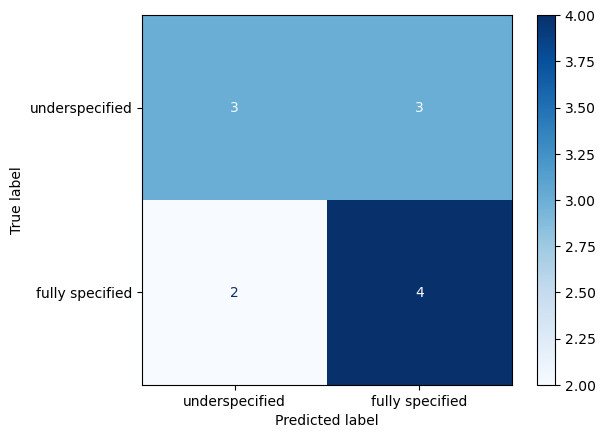

In [29]:
retrieve_results(trial_df, "0712trial_1")

# TEST

In [15]:
df_test_shuffled = df_test_1155.sample(frac=1, random_state=42).reset_index(drop=True)
dfs = np.array_split(df_test_shuffled, 5)
df_test_1 = dfs[0]
df_test_2 = dfs[1]
df_test_3 = dfs[2]
df_test_4 = dfs[3]
df_test_5 = dfs[4]

### Batch 1

In [ ]:
test_prompts = prepare_test_prompts(df_test_1, task_text, learning_df=df_in_context_learning, instruction_text=definitions_and_detailed_instructions, example_head=example_intro, theory=True)
print(test_prompts[0])

In [21]:
test_df_1 = run_experiment(test_prompts, df_test_1)
test_df_1

100%|██████████| 58/58 [2:27:07<00:00, 152.20s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,785,Who started the white out in college football?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who s...","{\n ""query"": ""Who started the white out in co...",fully specified
1,365,What is the name of the tower big ben is in?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""What ...","{\n ""query"": ""What is the name of the tower B...",fully specified
2,991,Who played ashley banks on fresh prince of bel...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Who played ashley banks on fres...",fully specified
3,133,What was the number one song on october 2 1975?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""What was the number one song on...",fully specified
4,1333,Tell me whether the following animals are part...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Tell me whether the following a...",fully specified
...,...,...,...,...,...,...,...
226,284,Does the skeleton of Ironus ignavus have soft ...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Does the skeleton of Ironus ign...",underspecified
227,1924,Melissa told Jennifer that the father-in-law s...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. So the...","{\n ""query"": ""Melissa told Jennifer that the ...",fully specified
228,1097,Find information about the latest phishing scams.,underspecified,IN3,"<think>\nOkay, let's tackle this query: ""Find ...","{\n ""query"": ""Find information about the late...",underspecified
229,300,I want to secure my online accounts. What are ...,fully specified,IN3,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""I want to secure my online acco...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.63      0.86      0.73       120
 underspecified       0.75      0.45      0.56       111

       accuracy                           0.66       231
      macro avg       0.69      0.65      0.64       231
   weighted avg       0.68      0.66      0.65       231



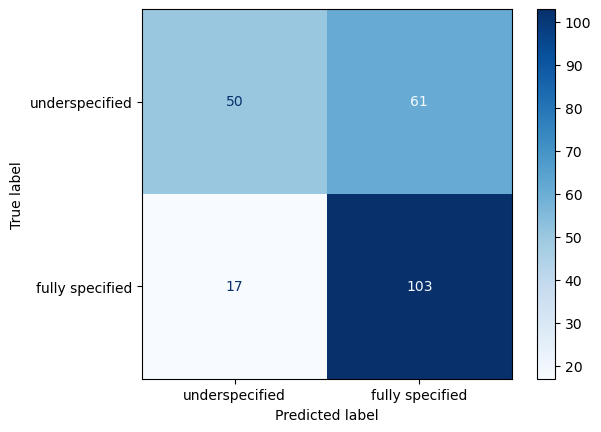

In [22]:
retrieve_results(test_df_1, "Qwen3_4B_UND_FS_NL_definitions_examples_wording_B_batch_1")

### Batch 2

In [ ]:
test_prompts = prepare_test_prompts(df_test_2, task_text, learning_df=df_in_context_learning, instruction_text=definitions_and_detailed_instructions, example_head=example_intro, theory=True)
print(test_prompts[0])

In [16]:
test_df_2 = run_experiment(test_prompts, df_test_2)
test_df_2

100%|██████████| 58/58 [2:24:34<00:00, 149.55s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
231,643,Who is the leader of ruling party in rajya sabha?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Who is the leader of ruling par...",fully specified
232,1873,What county is jersey city nj located in?,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""What county is jersey city nj l...",fully specified
233,814,Explain the basics of data analysis using pand...,fully specified,IN3,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Explain the basics of data anal...",fully specified
234,739,Make a probability distribution of rolling two...,fully specified,IN3,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Make a probability distribution...",fully specified
235,1524,Classify the below based on whether they are t...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Classify the below based on whe...",fully specified
...,...,...,...,...,...,...,...
457,848,Find the inverse and determinant for a matrix.,underspecified,IN3,"<think>\nOkay, let's tackle this query: ""Find ...","{\n ""query"": ""Find the inverse and determinan...",underspecified
458,495,Provide an overview of the Renaissance period ...,fully specified,IN3,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Provide an overview of the Rena...",fully specified
459,1004,When was the last world cup that brazil won?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When was the last world cup tha...",fully specified
460,855,Who plays harry in the amazing spider man 2?,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Who plays harry in the amazing ...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.62      0.82      0.71       121
 underspecified       0.69      0.45      0.55       110

       accuracy                           0.65       231
      macro avg       0.66      0.64      0.63       231
   weighted avg       0.66      0.65      0.63       231



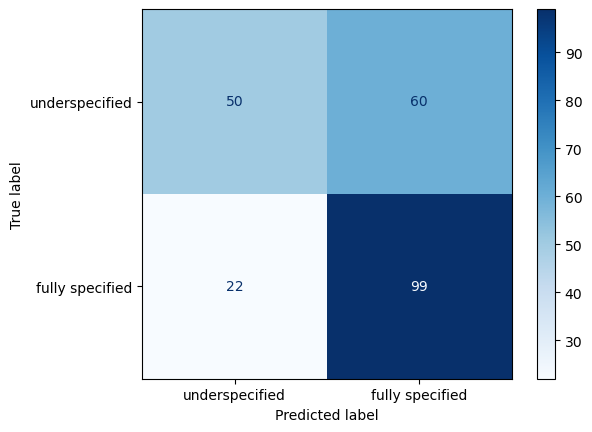

In [17]:
retrieve_results(test_df_2, "Qwen3_4B_UND_FS_NL_definitions_examples_wording_B_batch_2")

### Batch 3

In [ ]:
test_prompts = prepare_test_prompts(df_test_3, task_text, learning_df=df_in_context_learning, instruction_text=definitions_and_detailed_instructions, example_head=example_intro, theory=True)
print(test_prompts[0])

In [15]:
test_df_3 = run_experiment(test_prompts, df_test_3)
test_df_3

100%|██████████| 58/58 [2:22:57<00:00, 147.88s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
462,1011,How many base pairs in diploid human genome?,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""How m...","{\n ""query"": ""How many base pairs in diploid ...",fully specified
463,187,I often feel stressed. Can you find me some ev...,fully specified,IN3,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""I often feel stressed. Can you ...",fully specified
464,610,how do you win a ring,underspecified,CoCoNot,"<think>\nOkay, let's tackle this query: ""how d...","{\n ""query"": ""how do you win a ring"",\n ""rea...",underspecified
465,198,When did the capital of virginia moved from wi...,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""When did the capital of virgini...",fully specified
466,1115,Who plays simon's dad in the inbetweeners?,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who p...","{\n ""query"": ""Who plays simon's dad in the in...",fully specified
...,...,...,...,...,...,...,...
688,1220,How many starbucks are there around the world?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""How m...","{\n ""query"": ""How many starbucks are there ar...",fully specified
689,2301,In which studio recording was the song Wah-Wah...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query: ""In wh...","{\n ""query"": ""In which studio recording was t...",fully specified
690,644,What year did the ipod touch 4 come out?,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""What ...","{\n ""query"": ""What year did the ipod touch 4 ...",fully specified
691,50,who was the last person executed in the state ...,fully specified,CoCoNot,"<think>\nOkay, let's tackle this query: ""who w...","{\n ""query"": ""who was the last person execute...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.66      0.88      0.75       128
 underspecified       0.74      0.44      0.55       103

       accuracy                           0.68       231
      macro avg       0.70      0.66      0.65       231
   weighted avg       0.69      0.68      0.66       231



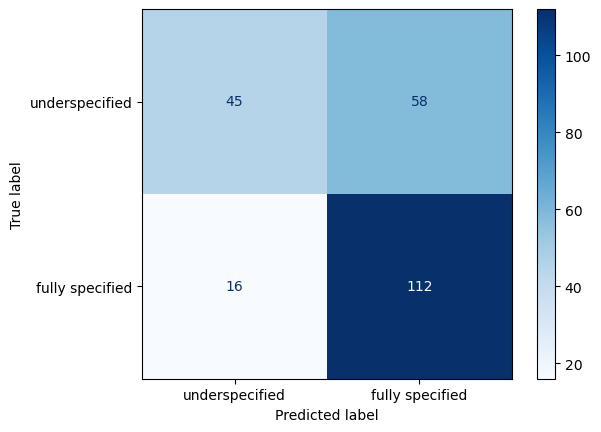

In [16]:
retrieve_results(test_df_3, "Qwen3_4B_UND_FS_NL_definitions_examples_wording_B_batch_3")

### Batch 4

In [ ]:
test_prompts = prepare_test_prompts(df_test_4, task_text, learning_df=df_in_context_learning, instruction_text=definitions_and_detailed_instructions, example_head=example_intro, theory=True)
print(test_prompts[0])

In [18]:
test_df_4 = run_experiment(test_prompts, df_test_4)
test_df_4

100%|██████████| 58/58 [2:58:24<00:00, 184.56s/it]  

Respond content: <think>
Okay, let's tackle this query. The user is asking, "William told Joshua that the saleswoman surprised him. Who did the saleswoman surprise?" 

First, I need to check if this is underspecified ...


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
693,2365,What does it mean to be observant?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""What ...","{\n ""query"": ""What does it mean to be observa...",fully specified
694,796,When was america taken off the gold standard?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When was america taken off the ...",fully specified
695,1658,Where was the show 13 reasons why filmed?,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Where...","{\n ""query"": ""Where was the show 13 reasons w...",fully specified
696,787,Locate the longest river in South America.,fully specified,IN3,"<think>\nOkay, let's tackle this query: ""Locat...","{\n ""query"": ""Locate the longest river in Sou...",fully specified
697,32,when was the treaty of 1763 signed in paris,fully specified,CoCoNot,"<think>\nOkay, let's tackle this query: ""when ...","{\n ""query"": ""when was the treaty of 1763 sig...",fully specified
...,...,...,...,...,...,...,...
919,65,Does Crop s minthe have larval development as ...,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Does Crop s minthe have larval ...",underspecified
920,83,Provide a list of materials needed and instruc...,underspecified,IN3,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Provide a list of materials nee...",fully specified
921,761,who is the first female engineer,underspecified,CoCoNot,"<think>\nOkay, let's tackle this query: ""who i...","{\n ""query"": ""who is the first female enginee...",underspecified
922,258,I want to learn Python. Provide me with a road...,underspecified,IN3,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""I want to learn Python. Provide...",fully specified


In [19]:
retrieve_results(test_df_4, "Qwen3_4B_UND_FS_NL_definitions_examples_wording_B_batch_4")

There are unrecognized labels.


In [24]:
missed_prompt = """
In what follows, I'll give you detailed definitions of "underspecified" and "fully specified" queries.

For "underspecified" queries, they belong to 4 main categories:

- **Missing necessary components**: There is a strong perception that for at least one expression within the query, a commonly expected component conceptually tied to it is missing, thus its semantic interpretation is left with an unfilled slot. As a result, the meaning of the whole query is underspecified.

- **Undetermined lexicons or references**: The query contains at least one expression of lexical or referential ambiguity. For this lexical or referential ambiguous expression,  multiple same-level entities or concepts can be mapped to it and serve as potential lexical entries or referents. It’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole query is underspecified.

- **Undetermined perspective or granularity**: The query contains at least one expression where the general meaning is in place, but its specific interpretation can still vary based on different perspectives or granularities adopted. Multiple interpretations of different levels or natures are plausible for such an expression, and it’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole query is underspecified.

- **Undetermined standard or preference**: The query contains at least one expression where the general meaning is in place, but its specific interpretation is vague due to unspecified contextual standards or subjective criteria. A wide range of fine-grained interpretations is possible according to contextual or subjective needs, and it’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole query is underspecified.

There is only one same-name category of "fully specified" queries, defined as follows:

- **fully specified**: The given query is totally clear and definitive, and it doesn't belong to any provided category of "underspecified" queries.



Here are examples of how to analyze queries:

{"query": "When was the first world war broke out?", "reasoning": "The phrase “broke out” can be interpreted from multiple perspectives or granularities. It can be interpreted from the perspective of the political trigger event, which is the assassination of Archduke Franz Ferdinand, or from the perspective of the formal military actions and declarations of war between major powers. The question remains underspecified before a certain perspective is chosen.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Who sings the song i will try to fix you?", "reasoning": "The question allows multiple granularities: it could be answered on the granularity of the band as a whole or specifically to the lead singer, Chris Martin. Without clarifying which granularity is meant, the question can be regarded as underspecified.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Who is the head of the nation in india?", "reasoning": "The question can refer to the role or title of the head (position) or to the specific person currently holding that role. Without clarifying the perspective, the intended meaning remains underspecified.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Moss is an example of which type of plant?", "reasoning": "The term “type” can refer to different taxonomic granularities, such as kingdom, clade, or division. Without specifying which classification level is intended, the question allows multiple valid interpretations and is therby underspecified.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "How long can you serve in the house?", "reasoning": "The term “house” is referentially ambiguous because it does not specify which legislative or organizational body is meant (e.g., House of Representatives, House of Lords) and which political entity (e.g. country) it is in. Additionally, “serve” can be interpreted under multiple perspectives, such as the length of a single term or the total number of years allowed. Both factors are making the intended meaning of the question underspecified.", "category": "Undetermined lexicons or references, Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "How much population is below poverty line in india?", "reasoning": "There are multiple possible data sources and definitions for measuring poverty, and the choice among them depends on the standard or preference applied. Additionally, the answer depends strongly on specifying the time period, but the question lacks this necessary temporal information. Both factors make the question underspecified.", "category": "Undetermined standard or preference, Missing necessary components", "judgment": "underspecified"}

{"query": "When did compulsory national service end in uk?", "reasoning": "The word “end” can be interpreted from multiple perspectives: it could refer to when the legislation was officially abolished or to when the last group of conscripted men completed their service and left the armed forces. Without specifying which perspective is meant, the question remains underspecified.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Who is the speaker of the house chosen by?", "reasoning": "The phrase “speaker of the house” has multiple homogeneous referents, such as the Speaker of the U.S. House of Representatives, the Speaker of the House of Commons in the UK, the speaker of the House of Commons in Canada, etc. Without specifying which political system or country is meant, the referent can't be determined and the question remains underspecified.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "What do you call a ten sided shape?", "reasoning": "The question can be interpreted from multiple perspectives depending on dimensional space — for example, it could refer to a two-dimensional decagon or a three-dimensional ten-faced decahedron. Without specifying the dimensional perspective, the intended meaning of the questionremains underspecified.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Where does the movie 10 things i hate about you take place?", "reasoning": "The phrase “take place” can be interpreted from heterogeneous perspectives: it could refer to the fictional story setting within the movie or to the actual filming location. Without specifying which is intended, the question remains underspecified.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "When does new episode of game of thrones come out?", "reasoning": "Since \"new\" can map to a temporal range, there can be multiple episode referents for the phrase  \"new episode\". Without clarifying which episode is meant, the question leaves multiple same-level referents undetermined and is thus underspecified.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "When does the movie dog days come out?", "reasoning": "The movie title “Dog Days” is referentially ambiguous because it can refer to several different films sharing the same or similar title. Additionally, the release date strongly depends on location (country or region), but the question lacks this necessary component to specify where. Both factors make the question underspecified.", "category": "Undetermined lexicons or references, Missing necessary components", "judgment": "underspecified"}

{"query": "Who plays lily on how i met your mother?", "reasoning": "There are several actresses who portray Lily at different ages in the show, meaning there are multiple same-level individual referents available. Without specifying which version or age of the character is meant, the question remains underspecified.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "Who did the song they're coming to take me away?", "reasoning": "The verb “did” can be interpreted from multiple perspectives in the context of song production: it could refer to the person who wrote the song, the one who produced it, the recording artist, or the lead singer. Without specifying which role is meant, the question remains underspecified.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Who were the four aces in the military's most wanted deck of cards?", "reasoning": "The phrase “military’s most wanted deck of cards” is referentially ambiguous because it can refer to several different decks; the most famous is the U.S. military’s deck from the Iraq War, but the Israeli IDF also has a similar deck for Hamas targets. Without specifying which deck is meant, multiple parallel referents are left undetermined and the question is underspecified.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "Who was the lead singer of the manhattans?", "reasoning": "The band had several different lead singers over various time periods, so answering the question depends on knowing which time frame is being referred to. Since the necessary time information is missing, the question is underspecified.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "Where is the pac 12 football championship played?", "reasoning": "This question refers to a recurring sports event, and the location can vary across different years. To answer it accurately, the specific time or year needs to be provided, but that necessary time information is missing.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "When is the fa cup semi final played?", "reasoning": "The question concerns the exact date of a recurrent sports event, thus its answer is strongly dependent on inputting the information of a specific year, but this information of a specific year is missing.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "Dragon ball z super next episode release date?", "reasoning": "\"next episode\" can potentially have multiple referents as no precise time information is available in the question.\n\nExternal retrieval of time to supplement the reasoning, but it doesn't mean that the question itself is not underspecified.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "When is a new season of fairy tail coming out?", "reasoning": "The phrase “next episode” can refer to multiple possible referents because, without specifying the exact point in time, it is unclear whether the question refers to the upcoming episode, a future season, or a delayed release. While external knowledge can help, the question itself remains underspecified.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "First clinical gene therapy was done for the treatment of?", "reasoning": "The word “done” can be interpreted from multiple perspectives: it could refer to the first-ever clinical attempt (implementation) or to the first successful and effective treatment. Without specifying which aspect is meant, the question can be regarded as underspecified.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Sharks rays and skates belong to what group?", "reasoning": "The term “group” can refer to multiple taxonomic granularities, such as class, subclass, or order. Without clarifying which classification level is intended, the question leaves room for multiple valid interpretations.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Who is the football coach at penn state?", "reasoning": "The phrase “football coach” can refer to several roles within the coaching staff, such as the head coach, offensive coordinator, or defensive coordinator. Without specifying which role is meant, the referent is left ambiguous.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "Find a way to convert audio files from one format to another using python.", "reasoning": "The task depends on user preference, such as the Python environment setup and the user’s familiarity with Python libraries. Additionally, it lacks clarity on which specific audio formats are involved, making the referents intended by \"one format to another\" undetermined. Both factors make the request underspecified.", "category": "Undetermined standard or preference, Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "Develop a Python script that logs daily food intake and calculates nutritional information.", "reasoning": "The request is underspecified because it does not clarify which kind of nutritional information should be calculated (e.g., calories, macronutrients, micronutrients) based on the user's standard or preference. Additionally, it does not specify which aspect or level of detail of the nutritional data is expected, making the granularity of the task ambiguous.", "category": "Undetermined standard or preference, Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Analyze the performance of the tech sector in the stock market last quarter.", "reasoning": "The request does not clarify which stock market or index is being referred to, leaving the referent vague. It also lacks details on which performance metrics are of interest, such as returns, volatility, or market share, making the evaluative standard and preference unclear. Additionally, it is unspecified which aspect or level of the tech sector should be analyzed, from broad sector-level trends to more detailed company-level performance, creating ambiguity in granularity. Combining all there factors, the request is underspecified.", "category": "Undetermined lexicons or references, Undetermined standard or preference, Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Develop a script to automate social media posts for my business.", "reasoning": "The request does not clarify what kind of business is involved, leaving the referent of \"my business\" vague. Additionally, it lacks details on preferences such as the desired post style, posting frequency, target language, and tone, all of which are essential for accurately fulfilling the request. Both factors make the request underspecified.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "Find a recipe for homemade pizza.", "reasoning": "This request is underspecified because it does not clarify the standard or preference regarding the type of pizza (e.g., Neapolitan, New York-style), any dietary restrictions (such as gluten-free or vegan), the desired difficulty level, or preferred toppings. Without specifying these aspects, the intended meaning of the request remains open, leaving multiple possible recipe options without clear guidance.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Find the next music festival happening in my city.", "reasoning": "The phrase “my city” lacks a clear referent, making it unclear which location is intended. Additionally, it does not specify what kind of music festival is preferred, such as genre, size, or type, leaving the search preference open. Both factors make the request underspecified.", "category": "Undetermined lexicons or references, Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Create a markdown document that documents the steps to install Python on a new system.", "reasoning": "The request is underspecified because it does not clarify which operating system the instructions should target (e.g., Windows, macOS, Linux) or which specific Python version to install, leaving both referents open and ambiguous.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "Write a Python script that sorts images based on their content.", "reasoning": "The request does not clarify the sorting standard or preference, such as whether the sorting should be by object type, color, or theme. Additionally, it is unclear which aspect of the image content should be used for sorting and how fine-grained the sorting should be, leaving the granularity ambiguous. Both factors make the request underspecified.", "category": "Undetermined standard or preference, Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Give tips on improving my storytelling abilities for writing fiction.", "reasoning": "The request is underspecified because it does not clarify which specific storytelling abilities the user wants to improve (e.g., plot structure, character development, dialogue) or what type of fiction they are interested in (e.g., genre, style), leaving the advice preference open.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Help me create a monthly budget plan to save for a new car.", "reasoning": "The request does not clarify which type of new car is intended, leaving the referent vague in terms of price range or model. Additionally, creating a budget plan requires subjective input on the user’s income, expenses, and savings preferences, which are not provided. Both factors make the request underspecified.", "category": "Undetermined lexicons or references, Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Devise a vegetarian recipe using only ingredients already in my pantry.", "reasoning": "The request does not specify which ingredients are actually in the user’s pantry, leaving the referent of  \"ingredients already in my pantry\" unclear. Additionally, creating a suitable vegetarian recipe would require more subjective input on the user’s taste preferences, dietary needs, and cooking style.", "category": "Undetermined lexicons or references, Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Locate the nearest yoga class with the best reviews in my city.", "reasoning": "The request does not clarify which city is meant, leaving the referent of \"my city\" vague. Additionally, terms like “nearest” and “best reviews” are subjective and can vary based on distance thresholds, review platforms, or rating standards, making the user's evaluative preferences unclear. Both factors make the request underspecified.", "category": "Undetermined lexicons or references, Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Write a summary of a given text file.", "reasoning": "The request does not clarify which specific text file is being referred to, leaving the referent of \"a given text file\" vague. Additionally, it does not specify the type or style of summary desired, such as a brief abstract, a detailed outline, or a key-point summary, making the user's preference unclear. Both factors make the request underspecified.", "category": "Undetermined lexicons or references, Undetermined standard or preference", "judgment": "underspecified"}

{"query": "I'm hosting a vegan dinner party this weekend, can you suggest a three-course meal with recipes?", "reasoning": "The request is underspecified because it does not clarify the number of guests to be served, leaving the portioning standard open. It also lacks preference details such as the type of cuisine (e.g., Italian, Asian-fusion) or the desired difficulty level of the recipes (e.g., simple, advanced). These are all essential for tailoring the three-course meal suggestion accurately, but they are lacking. Therefore, the request is underspecified.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Sketch a concept for a sustainable fashion line.", "reasoning": "The request is underspecified because it does not clarify the target audience for the fashion line, leaving the standard vague. Additionally, it lacks preference details such as the desired style (e.g., casual, formal) and the specific sustainability practices to focus on (e.g., recycled materials, fair labor). Furthermore, it is unclear how detailed the “concept” should be — whether it refers to a broad theme or a fully fleshed-out design plan — introducing ambiguity in granularity.", "category": "Undetermined standard or preference, Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Find out the file type and size of each file inside a specific directory.", "reasoning": "The request is underspecified because it does not clarify which specific directory is being referred to, leaving the referent ambiguous. Additionally, it lacks preference details such as the desired size unit for reporting file sizes (e.g., bytes, kilobytes, megabytes), which affects how the information should be presented. Both factors contribute to making the request underspecified.", "category": "Undetermined lexicons or references, Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Find the most popular men's fashion trends this spring.", "reasoning": "The request is underspecified because it does not clarify the standard for measuring “popular” (e.g., sales numbers, social media mentions, expert opinions) and does not specify which style category or subdomain of men’s fashion is preferred (e.g., formalwear, streetwear), both of which are needed to narrow down the trends accurately.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Search for an explanation of the String Theory.", "reasoning": "This request is underspecified because it does not clarify the standard or preference regarding the desired explanation — for example, whether the user wants a beginner-friendly overview, an advanced technical treatment, or a specific type of illustration (such as visual, textual, or mathematical). Additionally, the request leaves the perspective or granularity open, as it does not specify whether the explanation should focus on a particular sub-aspect of string theory or provide a broad general summary. Without these details, the intended output remains ambiguous.", "category": "Undetermined standard or preference, Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Keep me updated on the latest breakthroughs in renewable energy technology.", "reasoning": "The request is underspecified because it does not define what counts as a “breakthrough” (e.g., small incremental advances vs. major innovations), leaving the standard vague. Additionally, it is unclear whether the updates should cover the technology overall or focus on specific factors (e.g., storage, efficiency), creating ambiguity in perspective or granularity. Both factors make the question underspecified.", "category": "Undetermined standard or preference, Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Write a script to automate emails for a list of recipients based on certain events.", "reasoning": "The request is underspecified because the phrase “certain events” can refer to a parallel set of events (e.g., purchases, sign-ups) without specifying which ones, making the referent ambiguous. Additionally, the email content, target recipients, and what qualifies as an event are all subject to contextual standards or personal preferences, none of which are detailed, leaving the request open-ended. Both factors make the request underspecified.", "category": "Undetermined lexicons or references, Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Recommend the best smartwatches available in 2023.", "reasoning": "The request is underspecified because the term “best” relies on a subjective standard or preference, such as whether the user values battery life, design, fitness tracking, price, or brand reputation. Without specifying which criteria matter most, the recommendation remains open-ended.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Propose an idea for a community mural.", "reasoning": "The request is underspecified because it lacks details about the contextual standard of the community (e.g., cultural or social themes) and preferences regarding the mural’s intended message, artistic style, size, or placement location. Without this input, the proposal could vary widely in content and form.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Outline the steps to write and publish a novel for a first-time author.", "reasoning": "The request is underspecified because it does not clarify the user’s preferences, such as the desired genre, whether they aim for traditional or self-publishing, any budget constraints, or how detailed the guidance should be at each stage. These factors significantly shape the kind of advice provided.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Monitor the environment temperature, log the data, and alert if any abnormal value is detected.", "reasoning": "Determining specific key factors of this request requires more input about standards or preferences on the frequency of monitoring, what constitutes an 'abnormal' value, the method of logging, or the preferred method of alerting.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "How do I take professional-looking photos with my smartphone?", "reasoning": "First of all, the referent of \"my smartphone\" is not clear regarding which specific type of smartphone the user is using. Secondly, a helpful response to this question would require more input about the user's standard or preference about the type of photography they are interested in (e.g., portraits, landscapes, product photography) or any particular skills or techniques they wish to learn about. Both factors make the question underspecified.", "category": "Undetermined lexicons or references, Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Write a script to organize a directory of files by their extension types.", "reasoning": "The request is underspecified because it lacks details about the user’s standard or preference, such as which scripting language to use, the specific directory structure desired, how to handle files without extensions, or what to do with duplicate filenames after sorting. Without this input, the script’s design can vary significantly.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Craft a vegetarian meal plan for one week that includes all essential nutrients.", "reasoning": "The request is underspecified because it does not clarify the user’s preferences regarding caloric needs, any dietary restrictions within vegetarianism (e.g., lacto, ovo, vegan), desired meal variety, budget, cooking time, or any allergies or intolerances. It also does not specify the number of meals per day or whether snacks should be included, all of which affect the meal plan’s structure. ", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Summarize the main themes of the latest Pulitzer Prize-winning novel.", "reasoning": "The request is underspecified because the phrase “the latest Pulitzer Prize-winning novel” can refer to multiple works depending on when the question is asked, making the referent unclear. While external lookup can clarify the exact title, the question itself remains underspecified without that temporal anchoring.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "How can I save money on my monthly expenses?", "reasoning": "The request is underspecified because it lacks contextual standards about the user’s current spending habits, budget, and income, as well as their preferences regarding which expense categories they are most concerned about (e.g., housing, food, entertainment) and any specific financial goals they may have, all of which are necessary to provide targeted advice but missing.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "What are the most common questions asked in tech interviews and how should I answer them?", "reasoning": "The request is underspecified because the term “tech interviews” is broad and can lead to different responses depending on the perspective — such as developer roles, data science roles, or product management — and across different industries. Additionally, it lacks details about the user’s experience level or background that can help to form a solid user preference, which would significantly affect the type of advice on answering the questions. Both factors make the question underspecified.", "category": "Undetermined perspective or granularity, Undetermined standard or preference", "judgment": "underspecified"}

{"query": "when did we become a member of opec", "reasoning": "The request is underspecified because the referent “we” is ambiguous, as it could refer to multiple parallel countries depending on the user’s location or national identity. Without specifying which country is meant, the question remains underspecified.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "in census is done after a gap of every", "reasoning": "The request is underspecified because the political event tradition it refers to (census-taking) strongly requires the location or country to be specified, as census cycles vary significantly across nations. Without this necessary component, the question remains underspecified and cannot be accurately answered.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "when will the next senator be seated", "reasoning": "The request is underspecified because the political event tradition of senatorial seating strongly depends on specifying the location or legislative body. Without this essential information, the question lacks the necessary components to determine an answer.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "name of member who wrote constitution", "reasoning": "The request is underspecified because the term “constitution” can refer to multiple parallel documents from different countries or organizations. Without specifying which constitution is meant, the referent remains ambiguous.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "are we part of middle east or asia", "reasoning": "The request is underspecified because the referent “we” is ambiguous and can apply to multiple parallel countries depending on who is asking. Without clarifying which country “we” refers to, the geographic classification cannot be determined.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "what years were we pennies made of copper", "reasoning": "The request is underspecified because the referent “we” is unclear — it could refer to pennies from different countries (e.g., U.S., U.K., Canada), each with its own minting history. Without specifying the country, the timeline for copper pennies cannot be accurately provided.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "when was the death sentence abolished", "reasoning": "The request is underspecified because the abolishment of the death sentence depends on specifying the location or jurisdiction, as different countries or regions abolished it at different times. Without this necessary component, the question is underspecified and cannot be properly answered.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "when did the us get involved", "reasoning": "The request is underspecified because the phrase “get involved” strongly requires specifying which particular event or context (e.g., a war, a treaty, a crisis), as the U.S. has been involved in many historical events. Without this, the question lacks the necessary event anchor.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "when was the right to privacy established", "reasoning": "The request is underspecified because the establishment of the right to privacy depends on the legal and constitutional context, which necessarily requires specifying the country or jurisdiction. Without this, the question misses a necessary legal frame.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "who is the law minister", "reasoning": "The request is underspecified because official positions like “law minister” are inherently tied to a specific government, system, or political entity. Without specifying the country or jurisdiction, it is impossible to determine which law minister is being asked about.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "what type of government is the system", "reasoning": "The request is underspecified because the term “the system” can refer to multiple parallel political structures or frameworks across different countries or historical contexts. Without clarifying which system is meant, the referent remains ambiguous.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "a unilateral declaration that we was the policeman of the western hemisphere was the", "reasoning": "The request is underspecified because the referent “we” can apply to multiple political entities, though likely meant to refer to the U.S. Without explicitly specifying which entity made the declaration, the question remains underspecified.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "when was free health care introduced", "reasoning": "The request is underspecified because the introduction of healthcare policies, such as free health care, is highly dependent on the location or country, as each nation has its own timeline and implementation. Without specifying the location, the necessary component to answer the question is missing.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "who is running for governor of the state", "reasoning": "The request is underspecified because the term “state” can refer to multiple parallel political entities, such as different U.S. states, Australian states, or others. Without clarifying which state is meant, the referent remains ambiguous and prevents a precise answer, causing the question to be underspecified.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "when did the great depression end", "reasoning": "The request is underspecified because the notion of “end” can be interpreted from different perspectives or at different granularities — for example, the formal economic recovery, the end of specific policies, or the return of public confidence — each offering a heterogeneous angle. Without specifying the intended perspective, the question remains open-ended.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "where is the governor's mansion", "reasoning": "The request is underspecified because “the governor’s mansion” can refer to multiple parallel entities across different states or regions, each with its own official residence. Without specifying which governor or location, the referent remains ambiguous.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "ok google what's the capital", "reasoning": "The request is underspecified because the concept of “capital” is inherently tied to a specific political or administrative entity (e.g., country, state), but the question omits this essential component, making it impossible to determine which capital is being asked about. ", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "when did we split into east and west empires", "reasoning": "The request is underspecified because the pronoun “we” can refer to multiple parallel political entities or nations (e.g., Roman Empire, Germanic states, Cold War blocs), and the timeline depends entirely on which referent is intended. Without clarification, the question remains underspecified.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "when did the superannuation guarantee start", "reasoning": "The request is underspecified because the “superannuation guarantee” refers to a policy that necessarily depends on the country or jurisdiction, as different nations have different pension systems and start dates. Without specifying the location, the necessary component is missing.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "when did cape we become part of nova scotia", "reasoning": "The request is underspecified because the phrase “Cape we” lacks a clear referent — it’s unclear which geographic or political entity is being referred to in relation to Nova Scotia, making the reference ambiguous.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "when did the us take control", "reasoning": "The request is underspecified because the action “take control” necessarily requires both a subject (here, “the US”) and an object (what was taken control of), but the object is missing. Without knowing the target, the question lacks a critical component.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "who led a mission in 1846", "reasoning": "The request is underspecified because even though the time frame is limited to 1846, the term “a mission” can refer to many parallel referents — military, religious, diplomatic, or exploration missions — across different countries or contexts, leading to very different possible answers.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "when did we become part of the european union", "reasoning": "The request is underspecified because the pronoun “we” can refer to multiple parallel political entities or nations, and the answer changes entirely depending on which country or entity is intended. ", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "Name some famous anime shows?", "reasoning": "The request is underspecified because the notion of “famous” is subjective and depends on personal standards or preferences — it could refer to popularity, critical acclaim, cultural influence, or specific genres — making the selection criteria unclear. Therefore, the request is underspecified.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "How many years did deion sanders play baseball?", "reasoning": "“Play baseball” can be interpreted from different perspectives — for example, professional league play vs. minor leagues or exhibition games — introducing heterogeneous ambiguity. Additionally, the user's standard of what counts as “playing baseball” (e.g., roster presence, active participation) can vary, affecting the answer. Both factors make the question underspecified.", "category": "Undetermined perspective or granularity, Undetermined standard or preference", "judgment": "underspecified"}

{"query": "The sister-in-law told Amanda that the client glorified her. Who did the client glorify?", "reasoning": "The request is underspecified because the pronoun “her” has multiple same-level referents in the sentence (i.e., the sister-in-law or Amanda), creating referential ambiguity without additional clarification. Thus the question is underspecified.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "When did call of duty ww2 come out?", "reasoning": "The request is underspecified because the event of “coming out” (release/publication) is strongly tied to specific locations or regions, as release dates can differ internationally. Without specifying which market is intended, the question lacks a necessary component.", "category": "Missing necessary components", "judgment": "underspecified"}

{"query": "Kimberly told the aunt that she daunted the granddaughter. Who daunted the granddaughter?", "reasoning": "The request is underspecified because the pronoun “she” has multiple parallel referents (Kimberly or the aunt), creating referential ambiguity that prevents determining who performed the action.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "Give me a numbered list of five great fictional books.", "reasoning": "The request is underspecified because the term “great” relies on a subjective standard or preference — it could refer to literary acclaim, popularity, personal taste, or historical impact — without clarifying the intended criteria.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Where is the pga championship played in 2017?", "reasoning": "The request is underspecified because “where” can be answered on different levels of granularity, such as the specific venue, the host city, or the larger region. Without specifying the intended level, the question remains open-ended.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "How old do u have to be to get a tattoo in washington?", "reasoning": "The request is underspecified because “Washington” can refer to either the U.S. state or Washington, D.C., two separate jurisdictions with potentially different legal age requirements. Without clarifying the location, the referent remains ambiguous.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "Who sings i'm in love with my car?", "reasoning": "The request is underspecified because the question can be interpreted on different granularities — whether it refers to the lead vocalist specifically or to the band as a whole — leading to different levels of answer detail.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Write a paragraph of a blog post describing the appeal of a weekend stay at Blue Ridge Parkway?", "reasoning": "The request is underspecified because it lacks a clear standard (e.g., the target audience: families, couples, solo travelers) and preference details (e.g., whether to emphasize scenic views, recreational activities, or local culture), all of which shape the content’s focus.", "category": "Undetermined standard or preference", "judgment": "underspecified"}

{"query": "Who was thrown into the lion's den?", "reasoning": "The request is underspecified because multiple parallel referents exist depending on interpretive or cultural context — while many might assume the biblical figure Daniel, without explicit context, it could refer to other people who were thrown into it or other historical, literary, or metaphorical uses of the phrase.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "Which king saw the writing on the wall?", "reasoning": "The request is underspecified because while the concept can be decoded, multiple parallel referents could fit — such as the biblical Crown Prince of Babylon or figures alluded to symbolically (e.g., Antiochus IV Epiphanes). Meanwhile, the choice between different referents depends on different interpretive standards (literal vs. allegorical). Both factors affect the answer to this question.", "category": "Undetermined lexicons or references, Undetermined standard or preference", "judgment": "underspecified"}

{"query": "What's the concentration of nitrates in the water where Geuryphaorella lives?", "reasoning": "The request is underspecified because the referent “where Geuryphaorella lives” is unclear — without established scientific or geographic knowledge about this entity, no specific location or context can be determined to retrieve a nitrate concentration.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "What is the latitude range of Defselrea's habitat?", "reasoning": "The request is underspecified because no retrievable or recognizable referent exists for “Defselrea,” making it impossible to determine the relevant geographic or ecological context needed to answer the question.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "What's the average diameter of the cells of Pomozygosphaera?", "reasoning": "The request is underspecified because no identifiable referent or scientific concept for “Pomozygospheara” can be retrieved, leaving the biological or taxonomic context entirely unclear.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "The truth about the harry quebert affair tv show release date?", "reasoning": "\"The release date\" mentioned in this question can be interpreted from different perspectives, since the TV show Harry Quebert Affair had a pre-release of 35-minute scenes before the full release. As a result, the question can be answered both from the perspective of pre-release or the full release, making it underspecified.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Where was it came from outer space filmed?", "reasoning": "The request is underspecified because the action “filmed” can be interpreted from different perspectives — such as the soundstage (studio) locations versus the outdoor or on-site shooting locations — and the answer differs depending on which perspective is intended.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "When was the last time the giants went to the playoffs?", "reasoning": "The request is underspecified because “the Giants” can refer to multiple parallel referents, such as the New York Giants football team or the San Francisco Giants baseball team, and the correct answer depends entirely on which team is meant.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "What is the genre of Vishwaroopam?", "reasoning": "The request is underspecified because “Vishwaroopam” can refer to either the 2013 Indian film or the 2018 Indian television series, and the genre classification depends on which specific referent is intended.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "Give me a list of different cat species that are good for people with allergies.", "reasoning": "The request is underspecified because “allergies” is a broad term — it can serve as a description for general pet allergies or be further granularized into specific types (e.g., dander, saliva, fur), and the list of suitable cats would vary depending on the chosen granularity. Additionally, if the user seeks practical advice beyond a general list, the response would need more standard or preference input about which allergy types are most relevant.", "category": "Undetermined perspective or granularity, Undetermined standard or preference", "judgment": "underspecified"}

{"query": "The sister-in-law told Amanda that the client disliked her. Who did the client dislike?", "reasoning": "The request is underspecified because the pronoun “her” has two possible parallel referents: the sister-in-law or Amanda. Without disambiguation, the answer entirely depends on determining which referent is intended.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "What is the latitude range of icarchidae's habitat?", "reasoning": "The request is underspecified because no solid referent or recognizable concept for “Icarichidae” can be retrieved, making it impossible to meaningfully answer the geographic question.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "What's the latitude range where Oarcinidae is found?", "reasoning": "The request is underspecified because no identifiable referent or scientific concept for “Oarcinidae” is available, preventing meaningful retrieval of geographic or ecological data.", "category": "Undetermined lexicons or references", "judgment": "underspecified"}

{"query": "Where does the last name carson come from?", "reasoning": "This question is fully specified because it clearly provides the target (the surname Carson) and asks for its origin, without omitting necessary components. The term “Carson” refers unambiguously to the surname, so there is no lexical or referential ambiguity. The scope is straightforward, asking for factual etymological or geographic information, without involving multiple perspectives or levels of granularity. It also does not rely on subjective standards or preferences but calls for a factual answer.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who wrote the music for game of thrones?", "reasoning": "This question is structurally complete without missing components. There is no ambiguity in the reference, as “Game of Thrones” unmistakably refers to the TV series, and the composer is a well-documented factual attribution. The question does not leave room for different perspectives or levels of granularity, nor does it depend on any subjective criteria or standards.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who is the female singer in coldplay hymn for the weekend?", "reasoning": "This question is fully specified because it identifies both the song (Hymn for the Weekend) and the artist (Coldplay), and explicitly asks for the female vocalist involved, leaving no missing components. The reference is clear and unambiguous, as there is no competing interpretation of the song or the role of the female singer. The question focuses on a single factual point without requiring decisions about perspective or granularity, and it does not invoke subjective standards.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who played mike on fast times at ridgemont high?", "reasoning": "This question is fully specified because it unambiguously refers to the character Mike in the well-known film Fast Times at Ridgemont High and asks for the factual identity of the actor. There is no referential ambiguity, no missing details, no perspective shifts, and no subjective standard involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who was the first astronaut to die in space?", "reasoning": "This question is fully specified because it directly refers to a clear factual event: the first recorded astronaut fatality that occurred in space. The question does not omit necessary components, does not involve ambiguous references, does not require granularity decisions, and does not depend on subjective standards.", "category": "fully specified", "judgment": "fully specified"}

{"query": "What james bond movie came after casino royale?", "reasoning": "This question is fully specified because it clearly identifies the reference point (Casino Royale) within the James Bond film series and asks for the next official film, which is a factual sequence with no missing details. There is no ambiguity in the referents, no need to choose among perspectives or granularities, and no subjective standards involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Which term is described as small icy bodies that orbit the sun just beyond neptune ​?", "reasoning": "This question is fully specified because it refers to a well-defined astronomical category (commonly Kuiper Belt Objects) and asks for the standard term used, without lexical ambiguity or missing components. The scope is factual and does not require multiple perspectives or subjective judgments.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who is the actor that plays jorah mormont?", "reasoning": "This question is fully specified because it clearly refers to the character Jorah Mormont from the well-known TV series Game of Thrones and asks for the factual identity of the actor. There are no missing components, no referential ambiguity, no multiple perspectives, and no subjective standards involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who wrote the book no man is an island?", "reasoning": "This question is fully specified because it unambiguously refers to the book titled No Man Is an Island and seeks the factual author, which is a matter of record. There are no missing details, no ambiguous references, no competing perspectives, and no subjective criteria.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who sing the theme song to the jeffersons?", "reasoning": "This question is fully specified because it refers directly to the theme song of the TV show The Jeffersons and asks for the singer, which is a specific, factual attribution. The referents are clear, the scope is straightforward, and the request does not rely on subjective or multi-perspective considerations.", "category": "fully specified", "judgment": "fully specified"}

{"query": "What dog breed is duke from secret life of pets?", "reasoning": "This question is fully specified because it clearly refers to the character Duke from the animated movie The Secret Life of Pets and asks for the factual breed he is portrayed as. There are no missing components, no ambiguous references, no competing perspectives, and no subjective standards involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Where does the olfactory nerve exit the skull?", "reasoning": "This question is fully specified because it asks for a specific anatomical fact: the anatomical point where the olfactory nerve passes through the skull. The terms are precise, the referent is unambiguous, and there is no need for multiple perspectives or subjective interpretation.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who got constructed the moti masjid in delhi?", "reasoning": "This question is fully specified because it clearly refers to the Moti Masjid (Pearl Mosque) located in Delhi and asks for the factual historical figure responsible for its construction. While there are several mosques named Moti Masjid in India, the addition of “in Delhi” removes ambiguity, making the referent precise.", "category": "fully specified", "judgment": "fully specified"}

{"query": "The right to minimum wage is an example of?", "reasoning": "This question is fully specified because it asks for the general legal or political classification of the right to minimum wage (e.g., a socioeconomic right or labor right), which is a widely accepted factual category. There are no missing components, no ambiguous references, no competing perspectives, and no subjective standards affecting the interpretation.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who has more super bowl wins afc or nfc?", "reasoning": "This question is fully specified because it clearly refers to the comparative total of Super Bowl victories between the two NFL conferences (AFC and NFC), which is a factual, cumulative record. There are no missing components, no referential ambiguities, no competing perspectives, and no subjective standards involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Find the average lifespan of a domestic cat.", "reasoning": "This question is fully specified because it asks for a standard, factual statistic (the average lifespan) for a clearly defined category (domestic cats). There are no missing components, no ambiguous references, no competing perspectives, and no subjective standards involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Outline the key events leading up to the fall of the Berlin Wall.", "reasoning": "This question is fully specified because it asks for a factual historical sequence tied to a clear, singular event (the fall of the Berlin Wall in 1989). While “key events” might have some interpretive flexibility, it is generally understood to refer to major political and social milestones, not requiring subjective standards or missing details to proceed.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Explain the concept of black holes and how they are detected.", "reasoning": "This question is fully specified because it clearly asks for an explanation of an established astrophysical concept and its detection methods, both of which are well-documented in scientific literature. There are no missing components, no ambiguous references, and while the explanation can vary in depth, the core request is factually grounded and not dependent on subjective standards.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Look up the average salary for a software engineer in Austin, Texas.", "reasoning": "This question is fully specified because it clearly defines the job role (software engineer), the location (Austin, Texas), and the metric (average salary), making it a straightforward factual lookup. While finer details like the exact year or experience level could slightly affect the figure, the question asks at the macro level for an overall average, which is typically understood as referring to the most recent available data and the general average. Therefore, the request is sufficiently specified.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Research and summarize the concept of blockchain and its applications.", "reasoning": "This question is fully specified because it requests a factual summary of an established technical concept (blockchain) and its practical uses. While the applications can cover a range of areas, the question does not leave referential ambiguity, nor does it depend on subjective standards or multiple conflicting perspectives.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Find the capital city of Tasmania.", "reasoning": "This question is fully specified because it asks for a single, factual geographic fact — the capital of Tasmania — with no missing components, no ambiguous references, no multiple perspectives, and no subjective criteria.", "category": "fully specified", "judgment": "fully specified"}

{"query": "What are the current trends in sustainable fashion?", "reasoning": "This question is fully specified because it asks for an overview of the dominant trends within a defined topic (sustainable fashion) at the present time. While the trends themselves evolve, the phrase “current” anchors the scope and a very accurate time point is not required. The question also does not rely on ambiguous references or subjective standards beyond generally accepted industry reporting.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Summarize the causes and effects of the French Revolution.", "reasoning": "This question is fully specified because it refers unambiguously to the historical event of the French Revolution and asks for an overview of its causes and consequences, which are widely studied and documented. While different historians might emphasize different aspects or interpretations, the core factual scope of the request is clear, with no missing components, no referential ambiguity, and no reliance on subjective standards beyond established historical reporting.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Retrieve top 5 facts about the Eiffel Tower from Wikipedia.", "reasoning": "This question is fully specified because it clearly defines the target (the Eiffel Tower), the number of facts requested (top 5), and the source (Wikipedia), leaving no ambiguity in scope or reference. While the selection of “top” facts could vary slightly depending on presentation, the request is straightforward and does not rely on missing components or subjective standards.", "category": "fully specified", "judgment": "fully specified"}

{"query": "What is the average lifespan of a human in the 21st century?", "reasoning": "This question is fully specified because it asks for a statistical average lifespan over a defined period (21st century) for humans, which is a measurable, factual figure. There are no missing components, no ambiguous referents, and no subjective criteria involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "List the top five companies by market capital in the FTSE 100.", "reasoning": "This question is fully specified because it asks for a factual ranking based on a clear metric (market capitalization) within a defined index (FTSE 100). While the rankings change over time, the absence of a date reference does not undermine the general understanding that it refers to the current figures. There are no ambiguous references or subjective standards.", "category": "fully specified", "judgment": "fully specified"}

{"query": "List out the ten most spoken languages in the world.", "reasoning": "This question is fully specified because it clearly asks for a factual ranking (top ten languages) based on global speaker numbers, which is a well-documented statistic. While exact rankings may vary slightly depending on data sources, the request at the macro level is clear and does not involve ambiguous references or subjective criteria.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Solve this equation: 2x - 3 = 7.", "reasoning": "This question is fully specified because it presents a clear, closed mathematical problem with a unique solution. There are no missing components, no referential ambiguities, no competing perspectives, and no subjective standards involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "What's the westmost country in Asia?", "reasoning": "This question is fully specified because it asks for a specific geographic fact: the country located furthest west on the Asian continent. The terms are clear, and while geographic definitions can sometimes be debated (e.g., boundary lines), in common usage this refers to an accepted factual answer without ambiguity or missing information.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Imagine you are the last person on Earth. Write a diary entry describing your thoughts and feelings.", "reasoning": "This prompt is fully specified because it provides a clear fictional setup and asks the system to generate personal reflections within that context. There are no missing components, no ambiguous references, and no unclear perspectives — the request is open-ended in content but precise in task.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Give me a bulleted list of the seven more recent Indian Prime Ministers", "reasoning": "This request is fully specified because it clearly asks for a factual list: the seven most recent individuals to hold the office of Indian Prime Minister. There are no ambiguous references or missing details, and while “more recent” implies a time ordering, it is anchored by official historical records.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Name a famous American author who wrote stories about the American South during the early 20th century.", "reasoning": "This request is fully specified because it asks for a factual example of a well-known American author associated with Southern U.S. literature in the early 1900s. While multiple correct answers may exist, the request only asks to nominate one of them. The request is precise in scope and does not involve ambiguous references or missing components.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Classify each of the Super Bowl winners from the oldest to the most recent (first win): New England Patriots, Philadelphia Eagles, Tampa Bay Buccaneers, St Louis and NY Giants.", "reasoning": "This question is fully specified because it gives a clear list of teams and asks for an ordering based on the date of each team’s first Super Bowl win. The scope and reference are precise, and while historical sports data can evolve, the request is factual, with no ambiguity or subjective interpretation involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "How do you operate a car with a manual transmission?", "reasoning": "This question is fully specified because it asks for factual, procedural instructions on how to drive a manual (stick shift) car. The task is clearly defined, with no missing components, no ambiguous references, and no need for subjective standards or multiple perspectives.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Tell me what continent are these countries located: China, United States, India, France, Brazil.", "reasoning": "This question is fully specified because it requests factual geographic classifications, assigning each listed country to its corresponding continent. The referents are clear, the scope is factual, and there is no ambiguity or need for subjective interpretation.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who played the main roles in the movie Horns?", "reasoning": "This question is fully specified because it refers to the film Horns (2013) and asks for the factual names of the lead actors. The referent is clear, there are no missing components or ambiguous references, and while the cast list could include multiple prominent names, the request itself is straightforward.", "category": "fully specified", "judgment": "fully specified"}

{"query": "The son told Robert that Brian shouted at him. Who did Brian shout at?", "reasoning": "This question is fully specified because even though the pronoun “him” could theoretically refer to either Robert or the son, the meaning of the verb “shout at” involves a perceptual experience — the one shouted at must directly perceive the shouting, not just be informed about it by someone else. Therefore, “him” pragmatically resolves to the son, since Robert is only hearing about the shouting secondhand. The referents are clear, the semantic constraints narrow the interpretation, and no missing components or subjective judgments are needed.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who is the actress who played ophelia on the royals?", "reasoning": "This question is fully specified because it refers to the TV show The Royals and the character Ophelia, asking for the factual name of the actress who played her. While there is an Indian series also titled The Royals, the character Ophelia only appears in the American version, which effectively resolves any potential referential ambiguity. There are no missing components or subjective standards involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "The sister-in-law wrote a letter to Amanda because she wanted to apologize. Who wanted to apologize?", "reasoning": "This question is fully specified because the causal structure provided by “because she wanted to apologize” pragmatically resolves to the subject who initiated the action — the sister-in-law. The referents are internally traceable, and the semantics of apology (the apologizer is the one who acts) remove ambiguity without requiring external context or subjective interpretation.", "category": "fully specified", "judgment": "fully specified"}

{"query": "How did Robert Baratheon die?", "reasoning": "This question is fully specified because it asks for the cause or circumstances of death of a well-defined fictional character from Game of Thrones. The referent is clear, the scope is factual within the narrative world, and no missing components or subjective standards are involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who produced tupac movie all eyez on me?", "reasoning": "This question is fully specified because it refers specifically to the 2017 biographical film All Eyez on Me about Tupac Shakur, asking for the factual name(s) of the producer(s). There is no referential ambiguity, missing component, or subjective judgment required.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Does Lutica maculata have bilaterally symmetric body symmetry?", "reasoning": "This question is fully specified because it asks for a factual biological property (bilateral symmetry) of a certain spider species Lutica maculata. The referent is unambiguous, the scope is precise, and the question requires no subjective interpretation or missing contextual information.", "category": "fully specified", "judgment": "fully specified"}

{"query": "How many binary numbers can be created by no more than 4 digits?", "reasoning": "This question is fully specified because it asks for a precise mathematical count of binary numbers up to a length of 4 digits. The mathematical terms are clear, the scope is well-defined, and there are no ambiguous references or subjective standards involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "What's the average height of the vegetative part of Eugenia uniflora?", "reasoning": "This question is fully specified because it asks for a precise botanical measurement — the average vegetative height — for the well-defined plant species Eugenia uniflora. The referent is clear, the requested property is factual, and no missing components or ambiguous interpretations are involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Identify which car manufacturer is British or American: Land Rover, Jeep", "reasoning": "This question is fully specified because it asks for a factual classification of two specific car brands (Land Rover and Jeep) by their national origins (British or American). The referents are clear, the scope is precise, and no subjective judgments or missing contextual details are required.", "category": "fully specified", "judgment": "fully specified"}

{"query": "When was the canadian charter of rights and freedoms passed?", "reasoning": "This question is fully specified because it asks for a clear legal historical fact — the date the Canadian Charter of Rights and Freedoms was passed. The referent is unambiguous, the scope is precise, and no additional interpretive components or subjective standards are involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Give me a bulleted list of the 5 highest mountains in the world and their respective heights in meters", "reasoning": "This question is fully specified because it requests a factual, ranked list of the five tallest mountains on Earth, along with their heights in meters. The scope is clear, the referents are well known, and no ambiguous or subjective criteria are involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Who is the author of the novel Taipei by Tao Lin?", "reasoning": "This question is fully specified because it asks directly for the author of the novel Taipei, which is explicitly named in the question. There are no missing components, no ambiguous references, and the factual answer is uniquely anchored.", "category": "fully specified", "judgment": "fully specified"}

{"query": "What's the average body length of Brania russelli?", "reasoning": "This question is fully specified because it asks for a specific biological measurement — average body length — for the clearly named species Brania russelli. The referent is precise, the requested data is factual, and no interpretive ambiguity is involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Is Bolusia capensis a unicellular organism in terms of cellularity?", "reasoning": "This question is fully specified because it asks for the biological classification (unicellular or not) of the clearly named species Bolusia capensis. The referent is unambiguous, the requested property is factual, and no missing components or subjective perspectives are involved.", "category": "fully specified", "judgment": "fully specified"}

{"query": "Melissa told Jennifer that she cheated on the father-in-law. Who cheated on the father-in-law?", "reasoning": "This question is fully specified because, although the pronoun “she” might initially seem ambiguous, pragmatic cues in the sentence indicate that “Melissa” is the subject who cheated. The semantic structure of confession and directness supports a clear resolution without needing external clarification or interpretive framing.", "category": "fully specified", "judgment": "fully specified"}

When analyzing a given query, think step by step in an explicit way:

First, provide "reasoning" regarding whether it belongs to any of the provided categories of "underspecified" queries or the category of "fully specified" queries.

Second, assign a "category" to it. It can belong to multiple categories of "underspecified" at the same time, but categories of "underspecified" and the category of "fully specified" are mutual-exclusive.

Lastly, based on the "category" assigned, determine a "judgment" on whether it is "underspecified" or "fully specified". Categories of "underspecified" can only lead to a "underspecified" judgment, while the category of "fully specified" can only lead to a "fully specified" judgment.

Now analyze the following query:

{"query": "William told Joshua that the saleswoman surprised him. Who did the saleswoman surprise?"}

Think step by step as illustrated and provide your analysis in the following JSON format:
{"query": "William told Joshua that the saleswoman surprised him. Who did the saleswoman surprise?", "reasoning": "[YOUR_DETAILED_REASONING]", "category": "[CATEGORY]", "judgment": "[fully specified/underspecified]"}
"""

In [26]:
missed_thinking, missed_response = batch_generate_responses_qwen3(
    [missed_prompt],  # 包装成列表
    system_prompt=system_prompt,
    temperature=0.001,
    max_new_tokens=10000,
    batch_size=1, 
    enable_thinking=True,
    parse_thinking=True
)

100%|██████████| 1/1 [01:21<00:00, 81.57s/it]


In [30]:
print(missed_thinking[0])

<think>
Okay, let's tackle this query. The user is asking, "William told Joshua that the saleswoman surprised him. Who did the saleswoman surprise?" 

First, I need to check if this is underspecified or fully specified. Let's break it down. The main question is about identifying who the saleswoman surprised. The sentence says William told Joshua that the saleswoman surprised him. So, the "him" here refers back to William or Joshua?

Wait, the structure is William told Joshua that [saleswoman surprised him]. The pronoun "him" is the object of the verb "surprised." In English grammar, the pronoun usually refers to the subject of the previous clause. But here, the subject of the embedded clause is the saleswoman, and the object is "him." However, the antecedent of "him" could be either William or Joshua. Wait, but the sentence is structured as William telling Joshua something. The "him" in the subordinate clause would refer to the person who was surprised. 

But wait, the original stateme

In [31]:
print(missed_response[0])

{
  "query": "William told Joshua that the saleswoman surprised him. Who did the saleswoman surprise?",
  "reasoning": "The question asks for the object of the saleswoman's action ('surprise'). The pronoun 'him' in the embedded clause refers to the person who was surprised. Given the structure of the sentence, 'William' is the logical antecedent of 'him' because he is the subject of the main clause (the one telling the story) and the saleswoman's action would logically relate to his experience. The referent is unambiguous and does not require resolving ambiguity or multiple interpretations.",
  "category": "fully specified",
  "judgment": "fully specified"
}


### Batch 5

In [ ]:
test_prompts = prepare_test_prompts(df_test_5, task_text, learning_df=df_in_context_learning, instruction_text=definitions_and_detailed_instructions, example_head=example_intro, theory=True)
print(test_prompts[0])

In [17]:
test_df_5 = run_experiment(test_prompts, df_test_5)
test_df_5

100%|██████████| 58/58 [2:20:18<00:00, 145.15s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
924,43,when was the last time we had a republican may...,fully specified,CoCoNot,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""when was the last time we had a...",fully specified
925,174,Identify if the following instance is passive-...,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Identify if the following insta...",underspecified
926,150,How many islands are included in the federated...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""How many islands are included i...",fully specified
927,1819,When was the last time an astronaut went to th...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When was the last time an astro...",fully specified
928,665,Who sings the song if you want my love you got...,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Who sings the song if you want ...",fully specified
...,...,...,...,...,...,...,...
1150,362,Who did the land ordinance of 1785 benefit?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who d...","{\n ""query"": ""Who did the land ordinance of 1...",fully specified
1151,93,Is Bengalia depressa multicellular?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Is Be...","{\n ""query"": ""Is Bengalia depressa multicellu...",fully specified
1152,256,Does the developmental mode of Canthon hartman...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Does the developmental mode of ...",fully specified
1153,999,Who won season 2 of america's got talent?,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who w...","{\n ""query"": ""Who won season 2 of america's g...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.57      0.76      0.65       114
 underspecified       0.65      0.44      0.52       117

       accuracy                           0.60       231
      macro avg       0.61      0.60      0.59       231
   weighted avg       0.61      0.60      0.59       231



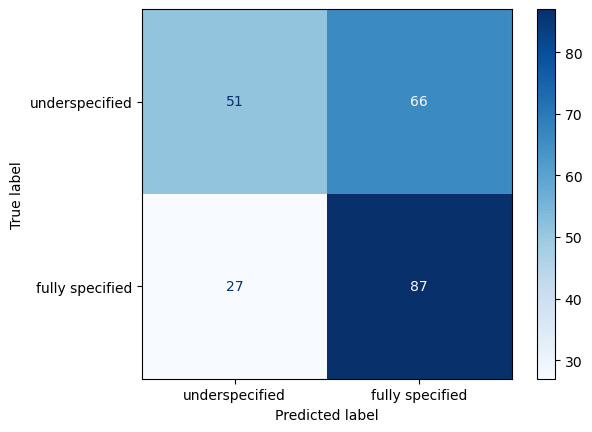

In [18]:
retrieve_results(test_df_5, "Qwen3_4B_UND_FS_NL_definitions_examples_wording_B_batch_5")

### Combine

No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.62      0.84      0.71       598
 underspecified       0.72      0.46      0.56       557

       accuracy                           0.65      1155
      macro avg       0.67      0.65      0.64      1155
   weighted avg       0.67      0.65      0.64      1155



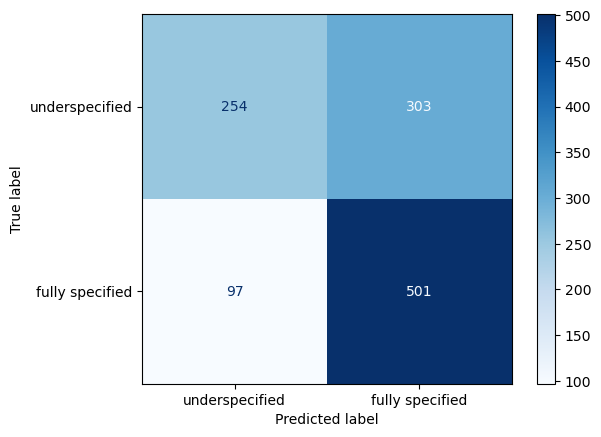

In [32]:
test_df_1 = pd.read_csv("Qwen3_4B_UND_FS_NL_definitions_examples_wording_B_batch_1.csv")
test_df_2 = pd.read_csv("Qwen3_4B_UND_FS_NL_definitions_examples_wording_B_batch_2.csv")
test_df_3 = pd.read_csv("Qwen3_4B_UND_FS_NL_definitions_examples_wording_B_batch_3.csv")
test_df_4 = pd.read_csv("Qwen3_4B_UND_FS_NL_definitions_examples_wording_B_batch_4.csv")
test_df_5 = pd.read_csv("Qwen3_4B_UND_FS_NL_definitions_examples_wording_B_batch_5.csv")

df_all = pd.concat([test_df_1, test_df_2, test_df_3, test_df_4, test_df_5])
retrieve_results(df_all, "Qwen3_4B_UND_FS_NL_definitions_examples_wording_B")

                 precision    recall  f1-score   support

fully specified       0.65      0.82      0.72       431
 underspecified       0.75      0.54      0.63       424

       accuracy                           0.68       855
      macro avg       0.70      0.68      0.68       855
   weighted avg       0.70      0.68      0.68       855



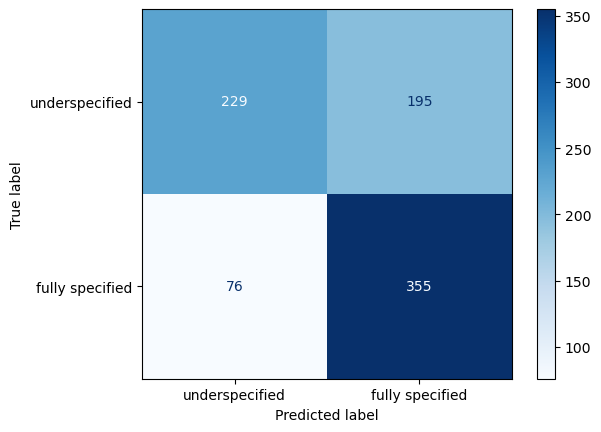

In [33]:
obtain_results_without('Qwen3_4B_UND_FS_NL_definitions_examples_wording_B.csv', 'AmbigQA')

## Qwen3-4B NL DEF

## TRIAL

In [13]:
trial_prompts = prepare_test_prompts(df_few_shots, task_text, instruction_text=definitions_and_detailed_instructions)
print(trial_prompts[0])

Start preparing prompts...
# Testing data points: 12
Generation complete: 12 prompts
Average prompt length: 3,260 bytes (~815 tokens)

In what follows, I'll give you detailed definitions of "underspecified" and "fully specified" queries.

For "underspecified" queries, they belong to 4 main categories:

- **Missing necessary components**: There is a strong perception that for at least one expression within the query, a commonly expected component conceptually tied to it is missing, thus its semantic interpretation is left with an unfilled slot. As a result, the meaning of the whole query is underspecified.

- **Undetermined lexicons or references**: The query contains at least one expression of lexical or referential ambiguity. For this lexical or referential ambiguous expression,  multiple same-level entities or concepts can be mapped to it and serve as potential lexical entries or referents. It’s impossible to fully determine which one is intended based on the provided content. As a r

In [14]:
trial_df = run_experiment(trial_prompts, df_few_shots)
trial_df

100%|██████████| 3/3 [01:07<00:00, 22.50s/it]


,request,gold_analysis,gold_thought,gold_category,gold_judgment,direct_source,thinking,model_response,model_pred
0,When did the nuclear accident happen?,"{""predicate"": ""happen"", ""argument_time"": ""when...","The predicate ""happen"" is specified; its argum...",underspecified referential/indexical argument,underspecified,CoCoNot,"<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When did the nuclear accident h...",underspecified
1,I need help picking out a professional wardrob...,"{""predicate"": ""provide"", ""argument_agent"": ""yo...","The predicate ""provide"" is specified; its argu...",underspecified quantified argument,underspecified,IN3,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""I need help picking out a profe...",underspecified
2,When did the apple tv 4k come out?,"{""predicate"": ""come out"", ""argument_time"": ""wh...","The predicate ""come out"" is underspecified bec...",underspecified predicate,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When did the apple tv 4k come o...",fully specified
3,Who sings i love rock 'n' roll? ...,"{""predicate"": ""sings"", ""argument_agent"": ""who""...","The predicate ""sings"" is specified; its argume...",underspecified argument concept,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Who s...","{\n ""query"": ""Who sings i love rock 'n' roll?...",fully specified
4,Where does the new fallout game take place?,"{""predicate"": ""take place"", ""argument_location...","The predicate ""take place"" is underspecified b...",multi-sourced underspecification,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Where...","{\n ""query"": ""Where does the new Fallout game...",fully specified
5,Who is the existing prime minister?,"{""predicate"": ""existing prime minister"", ""argu...","The predicate ""existing prime minister"" is spe...",missing argument,underspecified,CoCoNot,"<think>\nOkay, let's tackle this query: ""Who i...","{\n ""query"": ""Who is the existing prime minis...",underspecified
6,Who played the king in game of thrones season 1?,"{""predicate"": ""played"", ""argument_agent"": ""who...","The predicate ""played"" is specified; its argum...",fully specified request,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Who p...","{\n ""query"": ""Who played the king in game of ...",fully specified
7,Who plays henry tudor in the white princess?,"{""predicate"": ""plays"", ""argument_agent"": ""who""...","The predicate ""plays"" is specified; its argume...",fully specified request,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Who p...","{\n ""query"": ""Who plays henry tudor in the wh...",fully specified
8,Who won the contest to design the capitol buil...,"{""predicate"": ""won"", ""argument_agent"": ""who"", ...","The predicate ""won"" is specified; its argument...",fully specified request,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Who w...","{\n ""query"": ""Who won the contest to design t...",underspecified
9,How many daughters do George Washington have?,"{""predicate: ""have"", ""argument_theme"": ""how ma...","The predicate ""have"" is specified; its argumen...",fully specified request,fully specified,IN3,"<think>\nOkay, let's tackle this query: ""How m...","{\n ""query"": ""How many daughters do George Wa...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.62      0.83      0.71         6
 underspecified       0.75      0.50      0.60         6

       accuracy                           0.67        12
      macro avg       0.69      0.67      0.66        12
   weighted avg       0.69      0.67      0.66        12



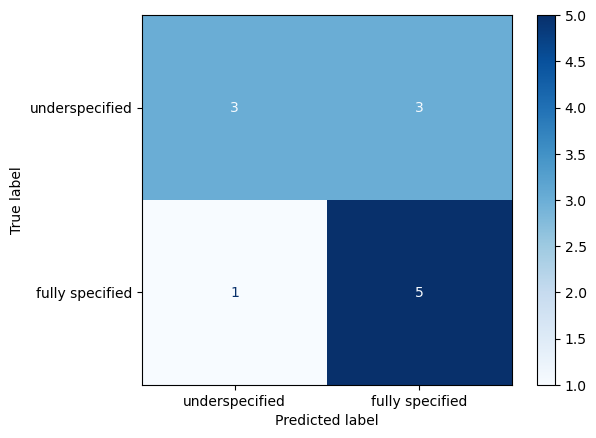

In [15]:
retrieve_results(trial_df, "0712trial_1")

## TEST

In [13]:
df_test_shuffled = df_test_1155.sample(frac=1, random_state=42).reset_index(drop=True)
dfs = np.array_split(df_test_shuffled, 3)
df_test_1 = dfs[0]
df_test_2 = dfs[1]
df_test_3 = dfs[2]

### Batch 1

In [ ]:
test_prompts = prepare_test_prompts(df_test_1, task_text, instruction_text=definitions_and_detailed_instructions)
print(test_prompts[0])

In [15]:
test_df_1 = run_experiment(test_prompts, df_test_1)
test_df_1

100%|██████████| 97/97 [1:18:43<00:00, 48.70s/it]


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,785,Who started the white out in college football?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who s...","{\n ""query"": ""Who started the white out in co...",underspecified
1,365,What is the name of the tower big ben is in?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""What ...","{\n ""query"": ""What is the name of the tower b...",underspecified
2,991,Who played ashley banks on fresh prince of bel...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Who p...","{\n ""query"": ""Who played ashley banks on fres...",fully specified
3,133,What was the number one song on october 2 1975?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""What ...","{\n ""query"": ""What was the number one song on...",underspecified
4,1333,Tell me whether the following animals are part...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. First,...","{\n ""query"": ""Tell me whether the following a...",fully specified
...,...,...,...,...,...,...,...
380,145,Are the sequences of Ptedoctematidae available...,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Are t...","{\n ""query"": ""Are the sequences of Ptedoctema...",underspecified
381,170,Read the following paragraph and answer a math...,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Read the following paragraph an...",underspecified
382,282,Is Calamaria griswoldi found in australasia bi...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Is Calamaria griswoldi found in...",fully specified
383,1165,When is the new series of doctor who coming on?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When is the new series of docto...",underspecified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.67      0.75      0.71       202
 underspecified       0.68      0.60      0.64       183

       accuracy                           0.68       385
      macro avg       0.68      0.67      0.67       385
   weighted avg       0.68      0.68      0.68       385



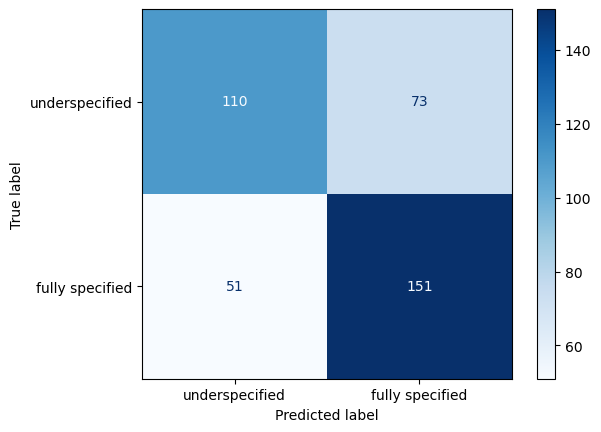

In [16]:
retrieve_results(test_df_1, "Qwen3_4B_UND_FS_NL_definitions_no_examples_wording_B_batch_1")

### Batch 2

In [ ]:
test_prompts = prepare_test_prompts(df_test_2, task_text, instruction_text=definitions_and_detailed_instructions)
print(test_prompts[0])

In [18]:
test_df_2 = run_experiment(test_prompts, df_test_2)
test_df_2

100%|██████████| 97/97 [1:12:56<00:00, 45.12s/it]


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
385,1053,Find the current most viewed livestream on Twi...,fully specified,IN3,"<think>\nOkay, let's tackle this query: ""Find ...","{\n ""query"": ""Find the current most viewed li...",fully specified
386,233,List out the current members of the United Nat...,fully specified,IN3,"<think>\nOkay, let's tackle this query: ""List ...","{\n ""query"": ""List out the current members of...",fully specified
387,1389,Who played grandpa joe in charlie and the choc...,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Who p...","{\n ""query"": ""Who played grandpa joe in charl...",underspecified
388,1252,When was the last time michigan was in the eli...,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When was the last time michigan...",fully specified
389,1248,Classify the sentences below based on the sent...,fully specified,CLAMBER,"<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""Classify the sentences below ba...",fully specified
...,...,...,...,...,...,...,...
765,1251,Who was the president of the United States in ...,fully specified,IN3,"<think>\nOkay, let's tackle this query: ""Who w...","{\n ""query"": ""Who was the president of the Un...",fully specified
766,1905,Who played draco malfoy in the harry potter mo...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Who p...","{\n ""query"": ""Who played draco malfoy in the ...",fully specified
767,1032,when did we become one of the leading manufact...,underspecified,CoCoNot,"<think>\nOkay, let's tackle this query: ""when ...","{\n ""query"": ""when did we become one of the l...",underspecified
768,1509,Who is jay park asia's got talent?,fully specified,AmbigQA,"<think>\nOkay, let me try to figure out if the...","{\n ""query"": ""Who is jay park asia's got tale...",underspecified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.67      0.75      0.71       202
 underspecified       0.68      0.60      0.64       183

       accuracy                           0.68       385
      macro avg       0.68      0.67      0.67       385
   weighted avg       0.68      0.68      0.68       385



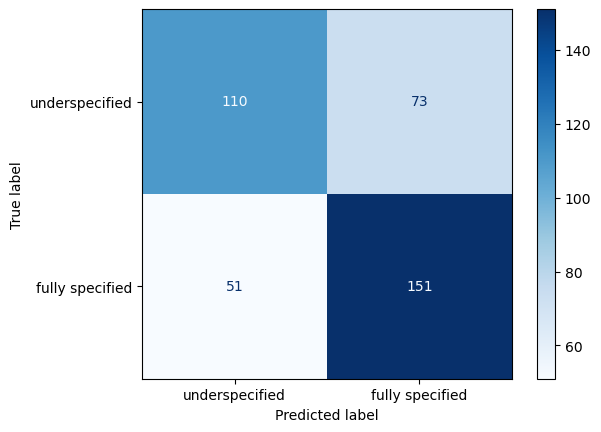

In [19]:
retrieve_results(test_df_1, "Qwen3_4B_UND_FS_NL_definitions_no_examples_wording_B_batch_2")

### Batch 3

In [ ]:
test_prompts = prepare_test_prompts(df_test_3, task_text, instruction_text=definitions_and_detailed_instructions)
print(test_prompts[0])

In [21]:
test_df_3 = run_experiment(test_prompts, df_test_3)
test_df_3

100%|██████████| 97/97 [1:16:42<00:00, 47.45s/it]


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
770,584,Who has a baby in pitch perfect 3?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who h...","{\n ""query"": ""Who has a baby in pitch perfect...",underspecified
771,419,I'm interested in amateur astronomy. Can you p...,fully specified,IN3,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""I'm interested in amateur astro...",fully specified
772,263,I need to declutter my closet. What's a good m...,underspecified,IN3,"<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""I need to declutter my closet. ...",fully specified
773,871,Who took hattrick in both innings in test?,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who t...","{\n ""query"": ""Who took hattrick in both innin...",underspecified
774,2353,What are some common symptoms of someone who i...,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""What ...","{\n ""query"": ""What are some common symptoms o...",underspecified
...,...,...,...,...,...,...,...
1150,362,Who did the land ordinance of 1785 benefit?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who d...","{\n ""query"": ""Who did the land ordinance of 1...",fully specified
1151,93,Is Bengalia depressa multicellular?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Is Be...","{\n ""query"": ""Is Bengalia depressa multicellu...",underspecified
1152,256,Does the developmental mode of Canthon hartman...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Does ...","{\n ""query"": ""Does the developmental mode of ...",fully specified
1153,999,Who won season 2 of america's got talent?,fully specified,CLAMBER,"<think>\nOkay, let me try to figure out if the...","{\n ""query"": ""Who won season 2 of america's g...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.67      0.75      0.71       202
 underspecified       0.68      0.60      0.64       183

       accuracy                           0.68       385
      macro avg       0.68      0.67      0.67       385
   weighted avg       0.68      0.68      0.68       385



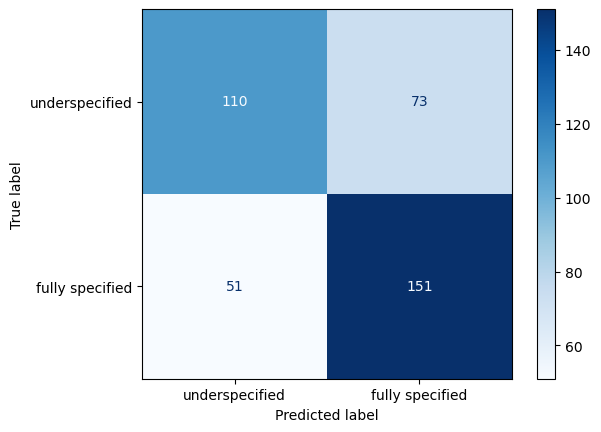

In [22]:
retrieve_results(test_df_1, "Qwen3_4B_UND_FS_NL_definitions_no_examples_wording_B_batch_3")

#### Combine

No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.67      0.75      0.71       606
 underspecified       0.68      0.60      0.64       549

       accuracy                           0.68      1155
      macro avg       0.68      0.67      0.67      1155
   weighted avg       0.68      0.68      0.68      1155



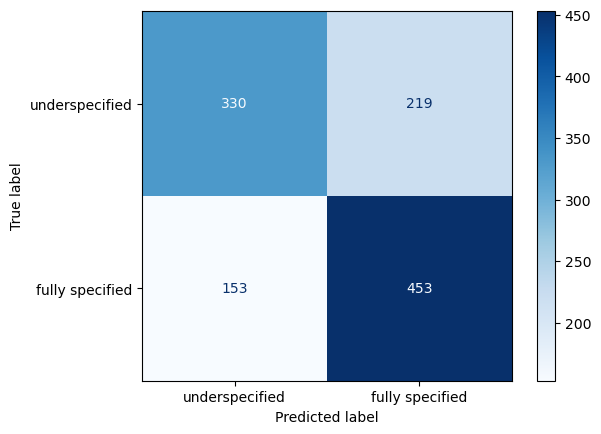

In [23]:
test_df_1 = pd.read_csv("Qwen3_4B_UND_FS_NL_definitions_no_examples_wording_B_batch_1.csv")
test_df_2 = pd.read_csv("Qwen3_4B_UND_FS_NL_definitions_no_examples_wording_B_batch_2.csv")
test_df_3 = pd.read_csv("Qwen3_4B_UND_FS_NL_definitions_no_examples_wording_B_batch_3.csv")

df_all = pd.concat([test_df_1, test_df_2, test_df_3])
retrieve_results(df_all, "Qwen3_4B_UND_FS_NL_definitions_no_examples_wording_B")

                 precision    recall  f1-score   support

fully specified       0.69      0.76      0.72       447
 underspecified       0.71      0.64      0.67       417

       accuracy                           0.70       864
      macro avg       0.70      0.70      0.70       864
   weighted avg       0.70      0.70      0.70       864



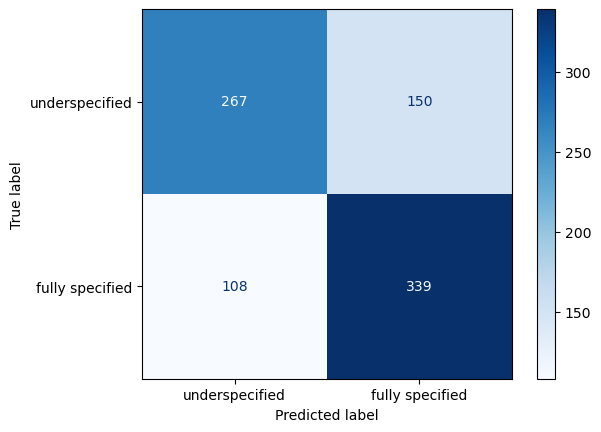

In [24]:
obtain_results_without('Qwen3_4B_UND_FS_NL_definitions_no_examples_wording_B.csv', 'AmbigQA')